In [23]:
import pandas as pd
%pip install requests
import requests
# USGSから過去1か月の地震データを取得
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
response = requests.get(url)

# データをファイルに保存
with open('earthquakes.csv', 'wb') as file:
    file.write(response.content)

# データをDataFrameに読み込む
data = pd.read_csv('earthquakes.csv')

# データの最初の5行を表示
data.head(100)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-11-18T05:10:03.849Z,31.652000,-104.316000,4.674500,1.60,ml,24.0,88.0,0.00000,0.30,...,2025-11-18T05:16:18.797Z,"58 km S of Whites City, New Mexico",earthquake,0.000000,1.141562,0.1000,17.0,automatic,tx,tx
1,2025-11-18T05:06:20.580Z,33.522499,-115.837334,7.470000,1.20,ml,37.0,135.0,0.04445,0.19,...,2025-11-18T05:10:02.145Z,"9 km E of North Shore, CA",earthquake,0.310000,0.550000,0.1233,26.0,automatic,ci,ci
2,2025-11-18T04:54:25.901Z,31.671000,-104.421000,6.802800,1.70,ml,27.0,70.0,0.00000,0.30,...,2025-11-18T05:00:14.047Z,"56 km S of Whites City, New Mexico",earthquake,0.000000,2.048719,0.1000,21.0,automatic,tx,tx
3,2025-11-18T04:45:38.990Z,40.030998,-123.782997,17.469999,2.00,md,21.0,71.0,0.05201,0.11,...,2025-11-18T04:52:19.869Z,"10 km SSE of Redway, CA",earthquake,0.390000,0.660000,0.1100,14.0,automatic,nc,nc
4,2025-11-18T04:36:31.218Z,31.891000,-101.666000,1.298600,1.20,ml,6.0,136.0,0.10000,0.60,...,2025-11-18T04:39:29.338Z,"17 km W of Garden City, Texas",earthquake,0.000000,3.923348,0.5000,6.0,automatic,tx,tx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2025-11-17T16:00:55.550Z,63.308300,-151.306800,0.000000,1.90,ml,NaN,NaN,NaN,0.55,...,2025-11-17T16:03:24.211Z,"33 km SE of Denali National Park, Alaska",earthquake,NaN,0.300000,NaN,NaN,automatic,ak,ak
96,2025-11-17T15:51:10.337Z,32.357000,-102.104000,7.885700,1.10,ml,15.0,45.0,0.00000,0.10,...,2025-11-17T16:34:47.646Z,"39 km NW of Stanton, Texas",earthquake,0.536187,0.882261,0.2000,11.0,reviewed,tx,tx
97,2025-11-17T15:44:24.320Z,38.821999,-122.811836,2.470000,1.37,md,24.0,56.0,0.01815,0.02,...,2025-11-17T17:22:21.252Z,"7 km NW of The Geysers, CA",earthquake,0.240000,0.420000,0.1200,25.0,automatic,nc,nc
98,2025-11-17T15:26:39.592Z,31.645000,-104.404000,6.762700,2.70,ml,16.0,76.0,0.00000,0.10,...,2025-11-17T22:59:44.492Z,"58 km S of Whites City, New Mexico",earthquake,0.696050,0.529191,0.1000,12.0,reviewed,tx,tx


In [1]:
# 国ごとの地震発生頻度ランキングと最大マグニチュードランキングを作成し、合計ポイントで順位付け
# 地震データには国情報が直接含まれていないため、place列から国名を抽出
# マグニチュード4.0以上のデータに絞る
data = data.loc[data["mag"] >= 4.0].copy()
#str.split(",").str[-1]でカンマ区切りの最後の部分を国名として抽出
data["country"] = data["place"].str.split(",").str[-1]

# 国ごとの地震発生頻度ランキング作成
ranking = data["country"].value_counts().head(10)

# 頻度ランキングのデータフレーム化
ranking_df = ranking.reset_index()
ranking_df.columns = ["country", "count"]

# 各国の最大マグニチュードを追加
max_mag_per_country = data.groupby("country")["mag"].max()
ranking_df["max_mag"] = ranking_df["country"].map(max_mag_per_country)

# ランキングを1から始める
ranking_df.index += 1
print(ranking_df)

NameError: name 'data' is not defined

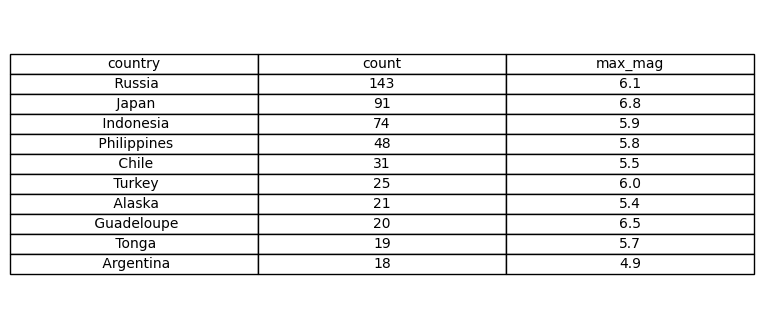

In [25]:
import matplotlib.pyplot as plt

# 表示したいデータ（上位10件だけ）
table_data = ranking_df[["country", "count", "max_mag"]].head(10)

# 図を作成
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')

# 表を作成
table = ax.table(cellText=table_data.values,
                 colLabels=table_data.columns,
                 cellLoc='center',
                 loc='center')

# 表のスタイルを整える
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# 画像として保存
plt.savefig("ranking_table.png", bbox_inches='tight', dpi=300)
plt.show()